In [1]:
import sys
sys.path.append('..')

from src.vector_store import load_vector_store
from src.config import VECTOR_DB_PATH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
print("Loading FAISS vector store...")
vectorstore = load_vector_store()

# Get all embeddings
index = vectorstore.index
embeddings = np.array([index.reconstruct(i) for i in range(index.ntotal)])

print(f"\n📊 Vector Store Statistics:")
print(f"  Total Embeddings: {index.ntotal}")
print(f"  Embedding Dimension: {index.d}")
print(f"  Index Size: {embeddings.nbytes / (1024**2):.2f} MB")

2026-02-15 10:18:43,769 - src.vector_store - INFO - Loading FAISS index from d:\Personal Trainer Assistant\notebooks\..\faiss_index


Loading FAISS vector store...


d:\Personal Trainer Assistant\notebooks\..\src\vector_store.py:75: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
2026-02-15 10:18:44,632 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
d:\Personal Trainer Assistant\venv\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2026-02-15 10:18:47,712 - faiss.loader - INFO - Loading faiss w


📊 Vector Store Statistics:
  Total Embeddings: 4699
  Embedding Dimension: 384
  Index Size: 6.88 MB



📈 Embedding Statistics:
  Mean: -0.0003
  Std Dev: 0.0510
  Min: -0.2782
  Max: 0.2689


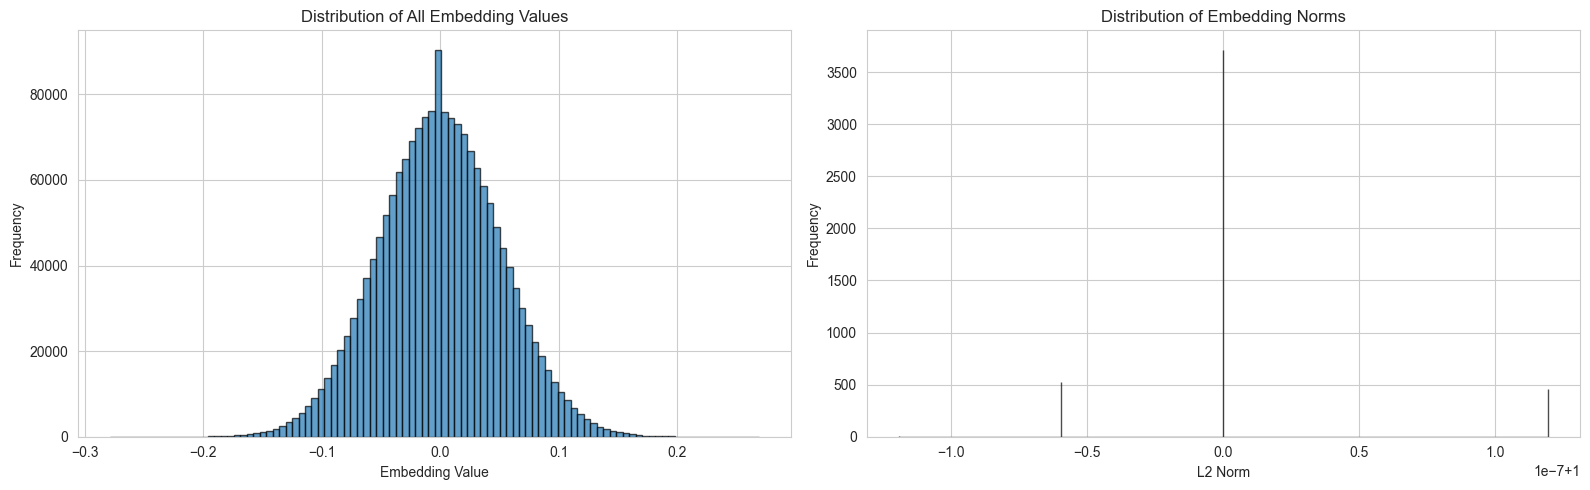

In [3]:
print("\n📈 Embedding Statistics:")
print(f"  Mean: {np.mean(embeddings):.4f}")
print(f"  Std Dev: {np.std(embeddings):.4f}")
print(f"  Min: {np.min(embeddings):.4f}")
print(f"  Max: {np.max(embeddings):.4f}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution of all embedding values
axes[0].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Embedding Values')

# Distribution of embedding norms
norms = np.linalg.norm(embeddings, axis=1)
axes[1].hist(norms, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('L2 Norm')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Embedding Norms')

plt.tight_layout()
plt.show()


Performing PCA...


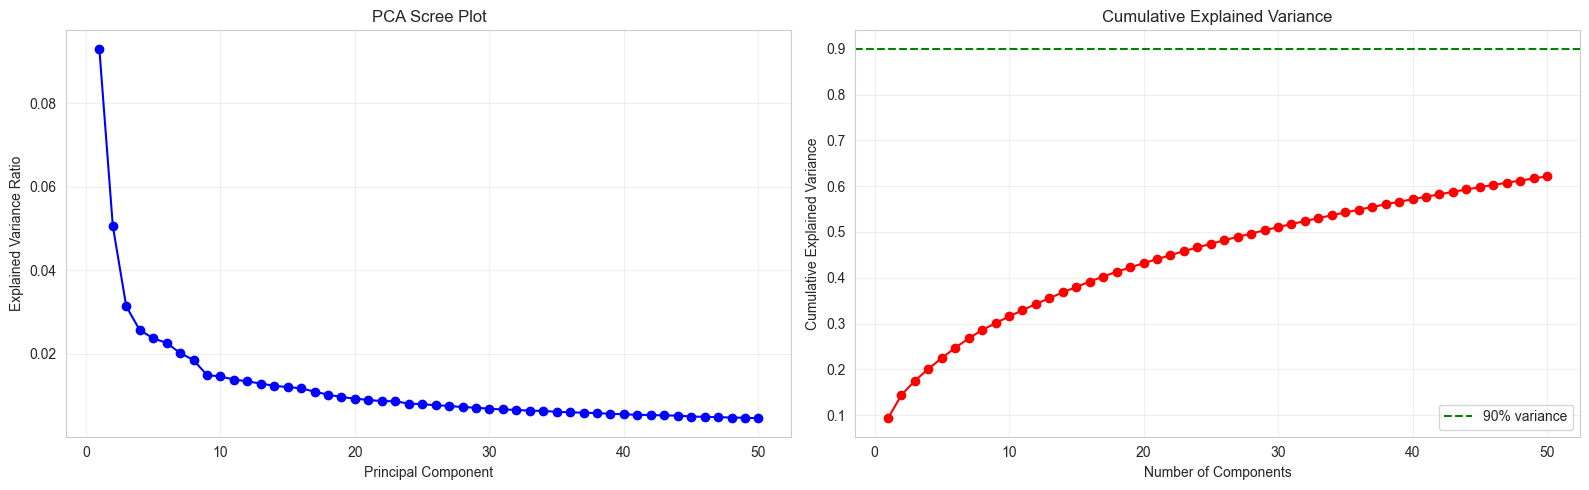


  Components for 90% variance: 1
  Components for 95% variance: 1


In [4]:
print("\nPerforming PCA...")

pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Explained variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].plot(range(1, 51), pca.explained_variance_ratio_[:50], 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, 51), cumsum_variance[:50], 'ro-')
axes[1].axhline(y=0.9, color='g', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n  Components for 90% variance: {np.argmax(cumsum_variance > 0.9) + 1}")
print(f"  Components for 95% variance: {np.argmax(cumsum_variance > 0.95) + 1}")


Performing t-SNE (this may take a few minutes)...


d:\Personal Trainer Assistant\venv\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


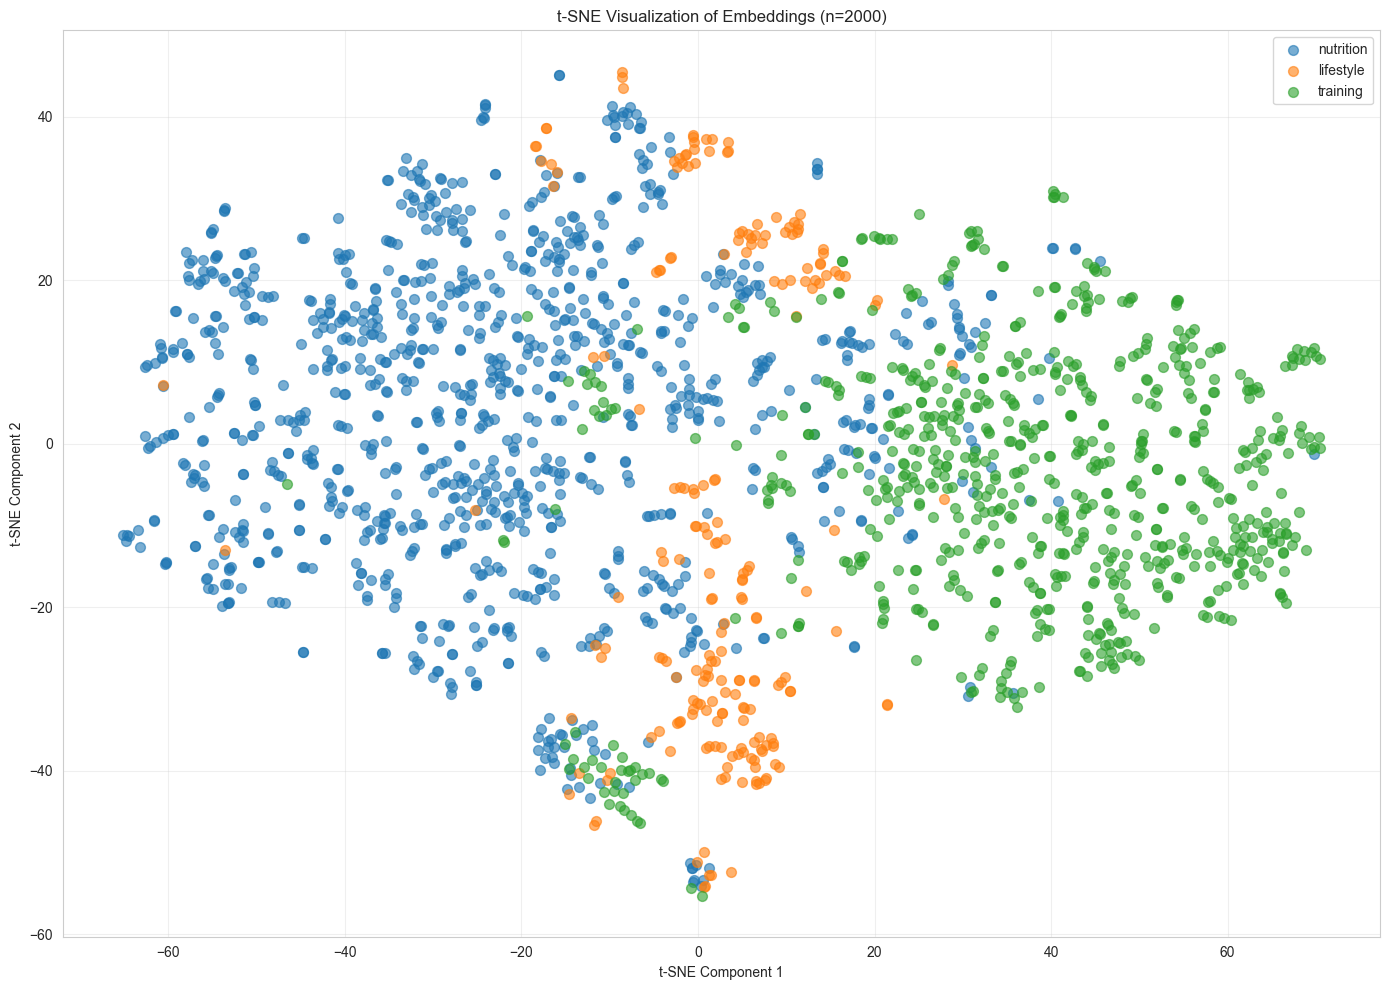

✅ t-SNE complete!


In [5]:
print("\nPerforming t-SNE (this may take a few minutes)...")

# Sample for speed (t-SNE is slow on large datasets)
sample_size = min(2000, len(embeddings))
sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)
embeddings_sample = embeddings[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_sample)

# Get categories for sampled embeddings
docs = [vectorstore.docstore.search(vectorstore.index_to_docstore_id[i]) 
        for i in sample_indices]
categories = [doc.metadata.get('category', 'unknown') for doc in docs]

# Create DataFrame
df_tsne = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'category': categories
})

# Plot
plt.figure(figsize=(14, 10))
for category in df_tsne['category'].unique():
    mask = df_tsne['category'] == category
    plt.scatter(df_tsne[mask]['x'], df_tsne[mask]['y'], 
               label=category, alpha=0.6, s=50)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f't-SNE Visualization of Embeddings (n={sample_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ t-SNE complete!")


🔍 Computing similarity statistics...

📊 Similarity Statistics:
  Mean Similarity: 0.1954
  Std Dev: 0.1475
  Min: -0.1617
  Max: 0.6426


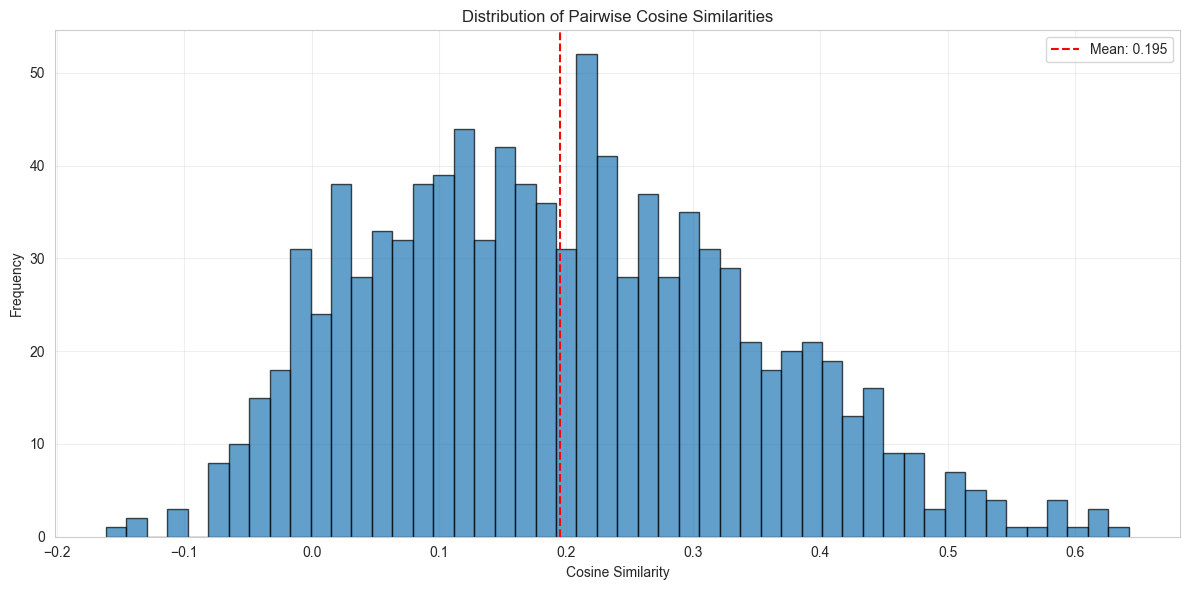

In [6]:
print("\n🔍 Computing similarity statistics...")

# Sample random pairs
n_samples = 1000
sample_pairs = np.random.choice(len(embeddings), (n_samples, 2), replace=True)

similarities = []
for i, j in sample_pairs:
    sim = np.dot(embeddings[i], embeddings[j]) / (
        np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
    similarities.append(sim)

print(f"\n📊 Similarity Statistics:")
print(f"  Mean Similarity: {np.mean(similarities):.4f}")
print(f"  Std Dev: {np.std(similarities):.4f}")
print(f"  Min: {np.min(similarities):.4f}")
print(f"  Max: {np.max(similarities):.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(similarities):.3f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Cosine Similarities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
summary = {
    'total_embeddings': index.ntotal,
    'embedding_dimension': index.d,
    'mean_embedding_value': float(np.mean(embeddings)),
    'std_embedding_value': float(np.std(embeddings)),
    'mean_norm': float(np.mean(norms)),
    'pca_components_90pct': int(np.argmax(cumsum_variance > 0.9) + 1),
    'mean_similarity': float(np.mean(similarities)),
}

print("\n" + "="*80)
print("📋 EMBEDDING ANALYSIS SUMMARY")
print("="*80)
for key, value in summary.items():
    print(f"  {key}: {value}")
print("="*80)


📋 EMBEDDING ANALYSIS SUMMARY
  total_embeddings: 4699
  embedding_dimension: 384
  mean_embedding_value: -0.0002917861274909228
  std_embedding_value: 0.05103020370006561
  mean_norm: 1.0
  pca_components_90pct: 1
  mean_similarity: 0.19539880752563477
